In [20]:
import cf_xarray.units  # noqa: F401
import pandas as pd
import pint
import pint_xarray  # noqa: F401
import plotly.express as px
import xarray as xr
from plotly import graph_objects as go

from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

## Commande

Paths :

```bash
SEAPODYM_EXECUTABLE = /Users/ash/Documents/Workspaces/Github/seapodym-project/seapodym-lmtl/build/bin/seapodym-lmtl

SEAPODYM_CONFIG_FILE = /Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/SEAPODYM_LMTL/configs/SEAPODYM_LMTL_D1N1.xml
```

Command :

```bash
mpirun -mca btl ^openib -np 6 "/Users/ash/Documents/Workspaces/Github/seapodym-project/seapodym-lmtl/build/bin/seapodym-lmtl" -P -G D1N1 -V error "/Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/2025-01-10_-_CAFE_HOT/zpk.tmpl.xml"
```


In [2]:
path_to_forcing = "../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_product = "/Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/2025-01-10_-_CAFE_HOT/output"
path_to_obs = "../../1_data_processing/1_1_Forcing/products/Hot_obs.zarr"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158

## Loading


### Prediction


In [6]:
biomass = xr.open_mfdataset(path_to_product + "/*.nc", combine="by_coords")
biomass.attrs["net_primary_production_model"] = "CAFE"
biomass = biomass.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
biomass.load()

In [7]:
with xr.set_options(keep_attrs=True):
    # biomass = biomass.pint.quantify() / (layer_depth.interp_like(biomass)[0, 0, :, 0] * pint.Unit("m"))
    biomass = biomass.pint.quantify()
    biomass = biomass.pint.to("mg/m^2")
biomass

Magnitude,[49.50709915161133 91.45659637451172 135.23428344726562 ... 197.01760864257812 197.1387939453125 205.5447998046875]
Units,milligram/meter2
Magnitude,[338.12982177734375 340.7279968261719 343.326171875 ... 312.044677734375 316.1488342285156 318.6613464355469]
Units,milligram/meter2


### Forcing


In [8]:
forcing = xr.open_zarr(path_to_forcing)
layer_depth = forcing["pelagic_layer_depth"].load()
layer_depth.attrs["units"] = "meter"
layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 9131,
                                         depth: 3)> Size: 219kB
array([[[[117.28651056, 351.85237634, 820.98410789],
         [119.6003271 , 358.80719094, 837.21089488],
         [117.12780113, 351.38460116, 819.89820122],
         ...,
         [126.2427347 , 378.72271938, 883.69271249],
         [127.85488846, 383.56085128, 894.97611817],
         [128.3260049 , 384.98088309, 898.28729822]]]])
Coordinates:
  * depth      (depth) int32 12B 1 2 3
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
Attributes:
    units:    meter

In [10]:
layer_depth = layer_depth.interp_like(biomass)
layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 1827,
                                         depth: 3)> Size: 44kB
array([[[[107.52922142, 322.5988858 , 752.73988518],
         [109.49053594, 328.46946435, 766.43650962],
         [112.57033434, 337.70050641, 787.97170963],
         ...,
         [119.82252031, 359.46291151, 838.74536455],
         [114.74465363, 344.23933523, 803.23036905],
         [112.54026308, 337.63034014, 787.80882363]]]])
Coordinates:
  * depth      (depth) int32 12B 1 2 3
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 15kB 2005-01-01T12:00:00 ... 2010-01-01T...
Attributes:
    units:    meter

### Observations


In [11]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.interp_like(biomass)
observations = observations.pint.quantify() * (layer_depth[0, 0, :, 0] * pint.Unit("m"))
observations

Magnitude,[[[[nan]]] [[[nan]]] [[[nan]]] ... [[[217.9351407543527]]] [[[208.37892067678075]]] [[[204.06134048128914]]]]
Units,milligram/meter2
Magnitude,[[[[287.79491266540924]]] [[[291.65592902872487]]] [[[298.43239198075446]]] ... [[[359.1859666902022]]] [[[345.2215989703606]]] [[[339.8225980761391]]]]
Units,milligram/meter2


## Plot


### Taylor Diagram


In [28]:
biomass_pandas = biomass.to_dataframe().reset_index().set_index("time")["zpk_epi"]
observations_day_pandas = observations.day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
observations_night_pandas = observations.night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
layer_pandas = layer_depth.to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

monthly_obs_day = observations_day_pandas.resample("ME").mean()["2002-01":"2020-01"]
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()["2002-01":"2020-01"]
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()["2002-01":"2020-01"]
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()["2002-01":"2020-01"]
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

monthly_data = pd.DataFrame(
    {
        "Observations (day)": monthly_obs_day,
        "Observations (night)": monthly_obs_night,
        "Predictions": monthly_pred,
    }
)
monthly_data = monthly_data.dropna()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



In [42]:
fig = go.Figure(
    layout={
        "title": "Seapodym Monthly Biomass (CAFE npp) and Observations : HOT station",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_data.index,
        y=monthly_data["Observations (day)"],
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_data.index,
        y=monthly_data["Observations (night)"],
        fill="tonexty",
        mode="lines",
        line={"color": "grey", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_data.index,
        y=monthly_data["Predictions"],
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [41]:
fig.write_html("seapodym_biomass_HOT_CAFE_by_epi_layer_depth.html")

correlation [0.3922091062151566]
norm STD [0.4219230246587752]
bias [0.10159155397642454]
NRMSE [0.9203558731727202]
name ['HOT D1N1']


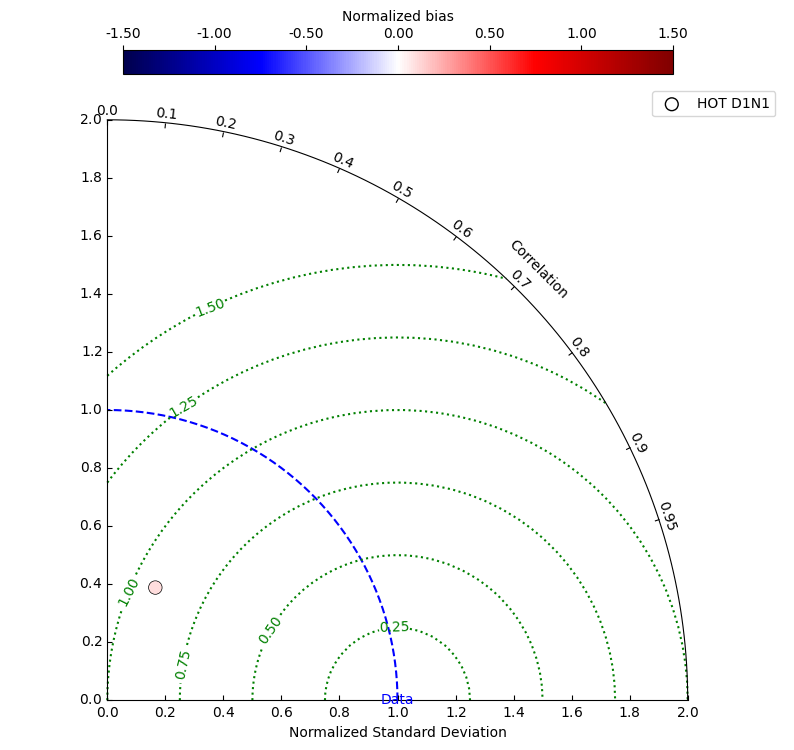

In [39]:
diagram = ModTaylorDiagram()

all_model = [monthly_data["Predictions"]]
all_obs = [monthly_data["Observations (day)"]]

all_names = ["HOT D1N1", "HOT D2N1"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()